# EE4211 Project - Question 2

Group name: WeUsOurs (Group No.26)

Group members: Liu Tianshu, Nie Hongtuo, Pan Jie, Zhang Chenxi

The whole code takes ~3 mins to finish running.

Please read our annotations while running the code:)

## Question 2.1

**Why you may want to forecast the gas consumption in the future?**

In the recently years, gas has begun to be widely used in power generation in both manufacturing and commercial.Accurate prediction of the gas consumpotioin could benefit us on several aspects:

1. Energy Saving.Knowing the gas demand could drive us to product the energy sources more efficiently. Unneceaasry waste could be reduced.
2. Energy Security.It allows the gas company to prevent and detect if there is any gas leakage during the transporting.
3. Urban Planning.The accurate and reasonable prediction of natural gas consumption is significant for the government to formulate the urban planning and infrastructure constructing.

**Who would find this information valuable?**

Government, gas user, gas company, gos distribution company,gas production countries and even our environment will benefit from it.

**What can you do if you have a good forecasting model?**

With the good forecasting model, we could:

1. Cooperate with gas industry to improve the efficiency.
2. Propose reasonable gas price according to the demand relation.
3. Analyse and improve the transporting security if the leakage happens regularly.

## Question 2.2 - Linear Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
plt.rcParams['figure.dpi'] = 300 # DPI setting

Read original data.

In [2]:
df = pd.read_csv('dataport-export_gas_oct2015-mar2016.csv')

In [3]:
def rectify(df):
    grouped = df.groupby(['dataid'])
    for key,group in grouped:
        val = group.meter_value.values
        diff = val[1:] - val[:-1]
        defect_time = np.where(diff < 0)[0] + 1
        if len(defect_time):
            for i in range(1,len(val)):
                if val[i] > val[-1]:
                    val[i] = val[i - 1]
                elif val[i] < val[i - 1]:
                    val[i] = val[i - 1]
            df.loc[df['dataid'] == key, 'meter_value'] = val
    return df

In [4]:
df = rectify(df)

As some data has imcomplete timestaps, we need to tidy the time information into Python timestamp format. 
(This may take a while to process.)

In [5]:
# turn into timestamp
def local2utc(time):
    return pd.Timestamp(time)
df.localminute = df.apply(lambda r: local2utc(r.localminute), axis=1)


As we are going to predict the value for the next hour, we decide to calculate the average hourly reading base on the actual dataset first.

In [15]:
def hourly_origin(df):
    groups = df.groupby(['dataid'], sort=['localminute'])
    processed_group = {}
    for key in groups.groups.keys():
        new_group = []
        current_group = groups.get_group(key).values
        tmp = []
        for row in current_group:
            row[0] = row[0].replace(minute = 0, second = 0, microsecond = 0, nanosecond = 0)
            tmp.append(row)
        current_group = tmp
        # mean
        mean_group = []
        current_time = None
        current_number = 0
        current_count = 0
        for i in current_group:
            if current_time is None:
                current_time = i[0]
                current_number = i[2]
                current_count = 1
            elif current_time.year == i[0].year and current_time.month == i[0].month and current_time.day == i[0].day and current_time.hour == i[0].hour:
                current_number += i[2]
                current_count += 1
            else:
                mean_group.append([current_time, key, (current_number / current_count)])
                current_time = i[0]
                current_number = i[2]
                current_count = 1
        mean_group.append([current_time, key, (current_number / current_count)])
                
        processed_group[key] = mean_group
    return processed_group

Extract all the meters' readings from dataset.

In [16]:
hourly_original_data = hourly_origin(df)

Select the meter ID that you want to inspect.

In [66]:
key = 9134 # meter ID


In [67]:
data = np.array(hourly_original_data[key]) # convert to np.array
y = data[:,2]
x = np.arange(len(y))
x = x.reshape(-1, 1)

In [68]:
# create linear regression object
lr = linear_model.LinearRegression()

# train the model using the training sets
lr.fit(x, y)

# make predictions using the testing set
y_pred = lr.predict(x)

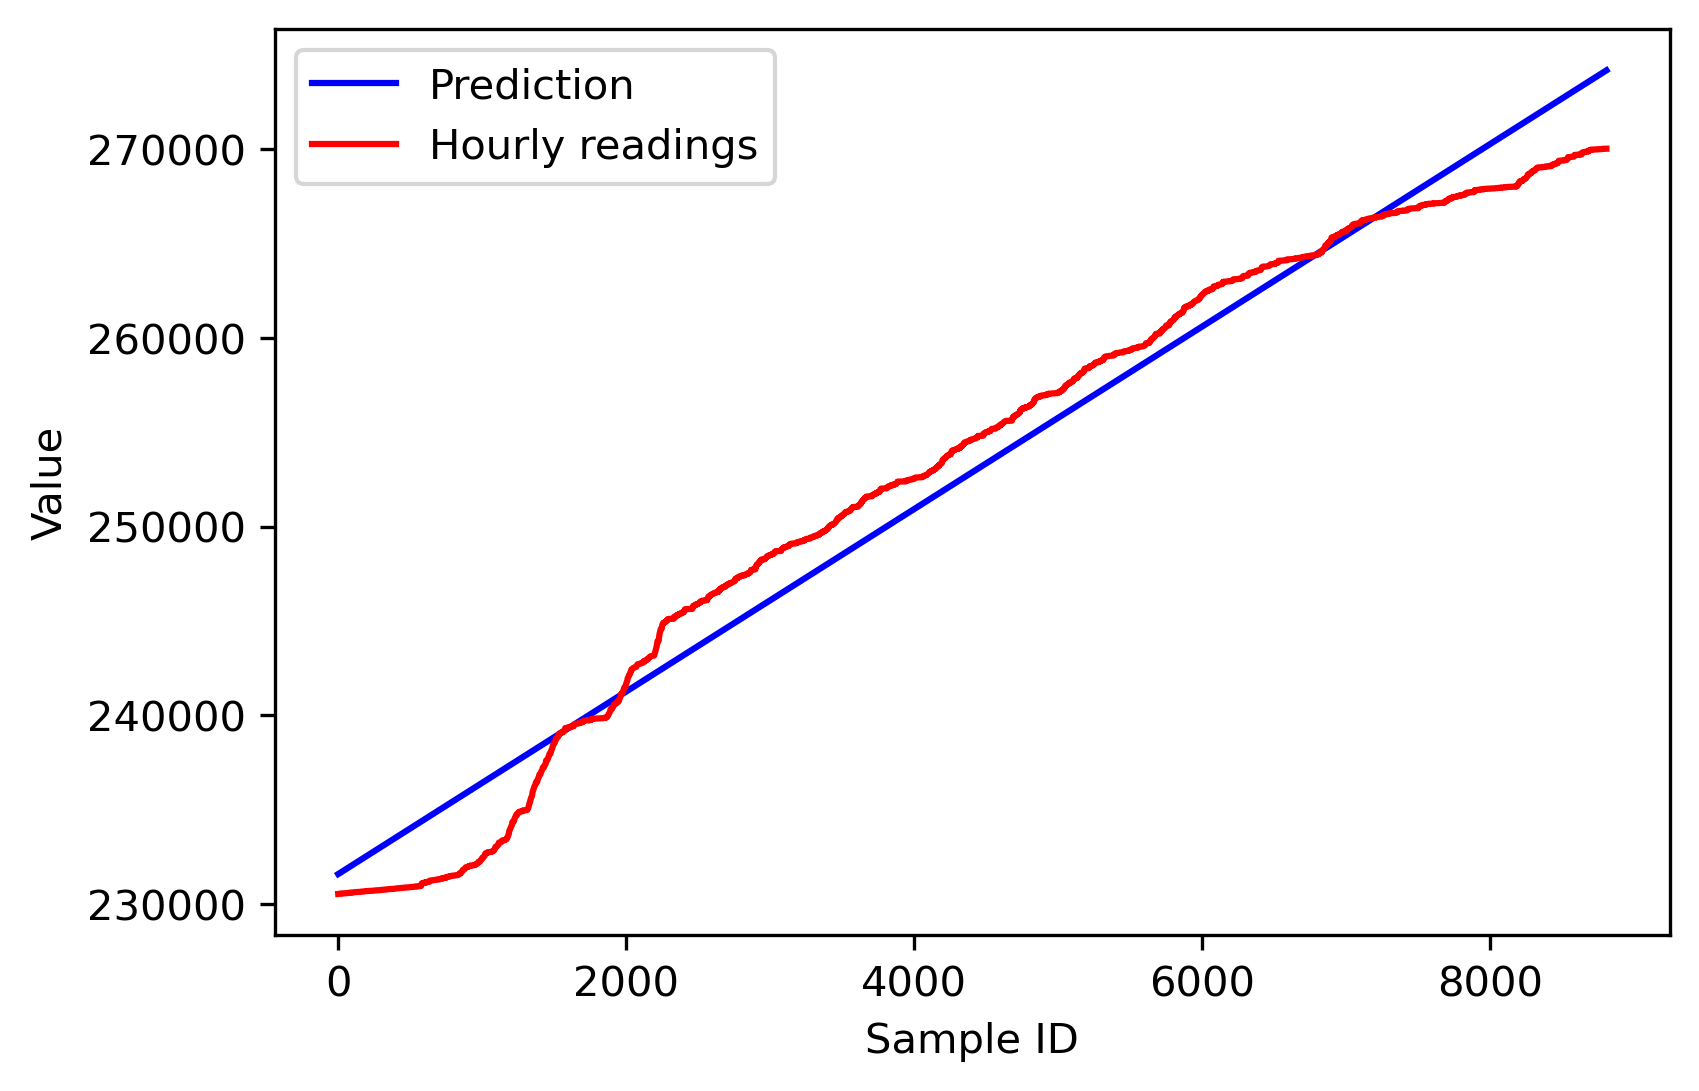

In [69]:
fig, ax = plt.subplots()
ax.plot(x, y_pred, '-b', label='Prediction')
ax.plot(x, y, '-r', label='Hourly readings')
plt.xlabel('Sample ID')
plt.ylabel('Value')
leg = ax.legend();

In [70]:
# the coefficients
print('Coefficients: \n', lr.coef_)
# the mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y, y_pred))
# the coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y, y_pred))

Coefficients: 
 [4.83516807]
Mean squared error: 4296110.79
Coefficient of determination: 0.97


From the result above we can see, the average hourly gas usage of this family is 4.8 $m^3$. We used $MSE$ and $R^2$ score to estimate the accuracy of our prediction.

Let's zoom in to have a close look:

In [71]:
section = np.arange(1800, 2200)

As we use the hourly reading during the previous question, here we continute using the hourly reading to have a clear version about how good the prediction fits.

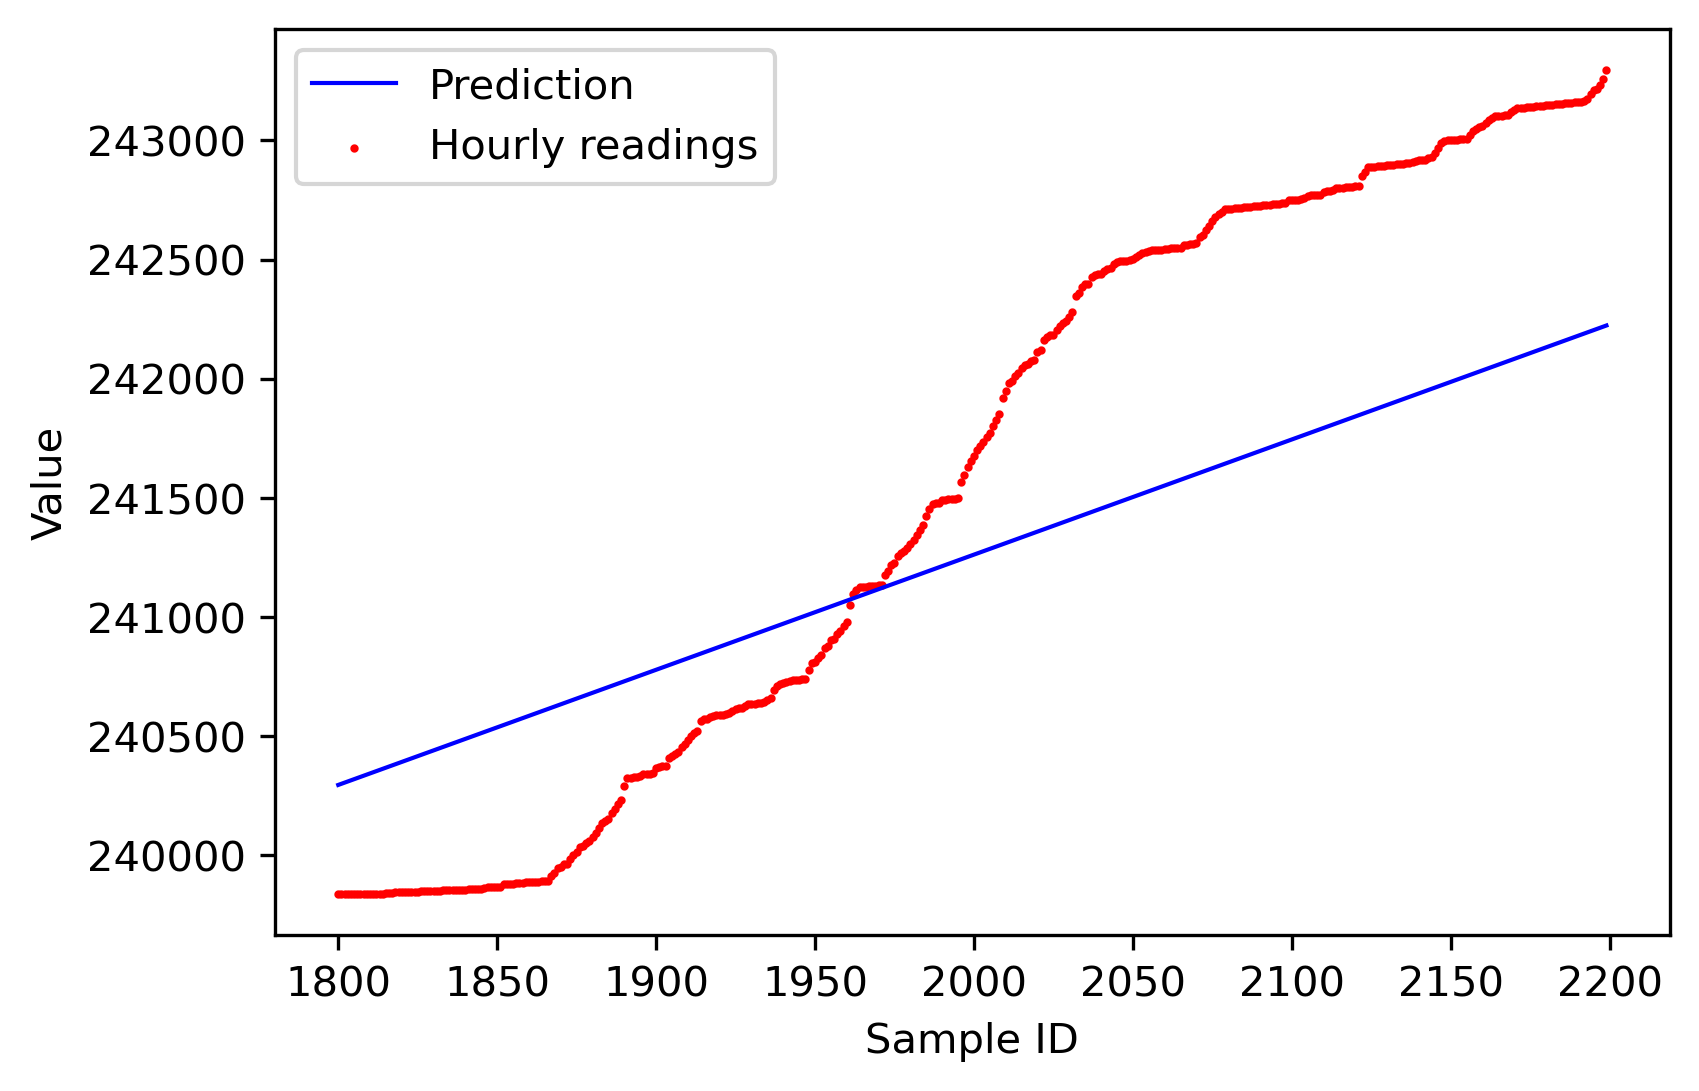

In [72]:
plt.scatter(x[section], y[section],  color='red', s=1)
plt.plot(x[section], y_pred[section], color='blue', linewidth=1)
plt.xlabel('Sample ID')
plt.ylabel('Value')
plt.legend(['Prediction', 'Hourly readings'], loc='best')

## Question 2.3 - Support Vector Regression

In the Question 2.3, we use SVR to predicture the reading.

In [48]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

svreg = make_pipeline(StandardScaler(), SVR(C=1000.0, epsilon=0.2))
svreg.fit(x, y)
y_pred = svreg.predict(x)

Same as the previous question, we use hourly readings to start the predict.

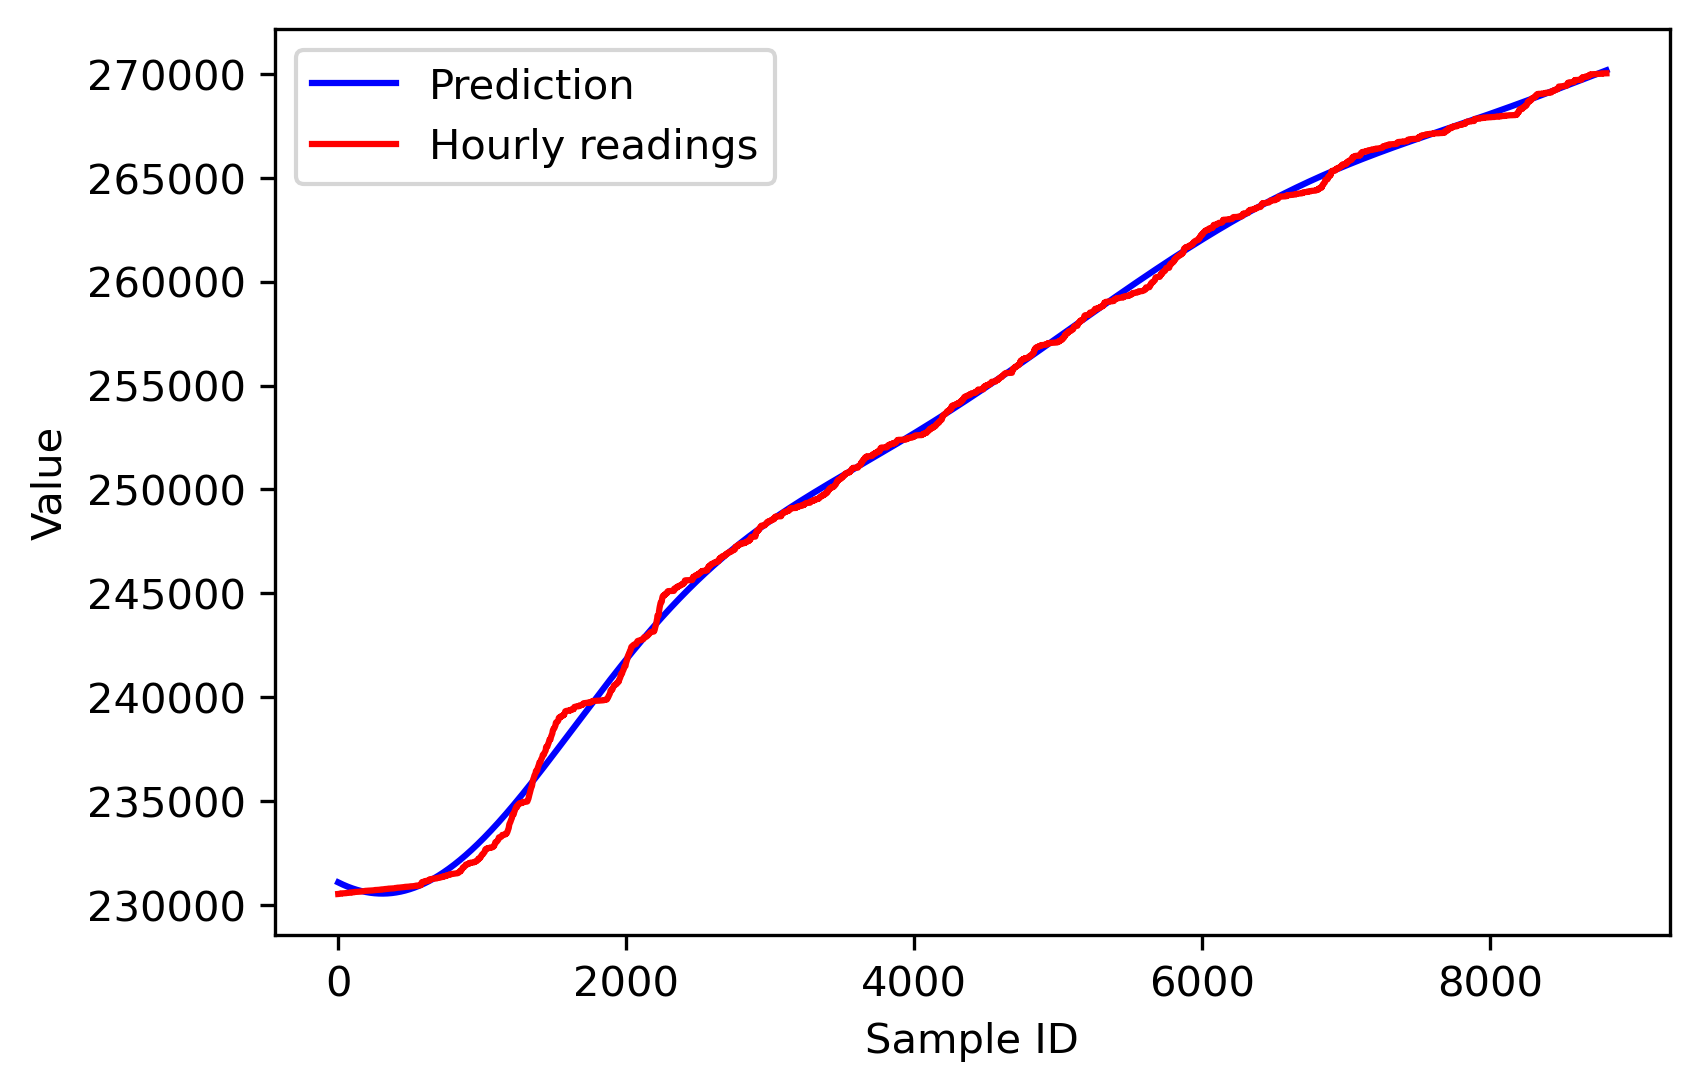

In [49]:
fig, ax = plt.subplots()
ax.plot(x, y_pred, '-b', label='Prediction')
ax.plot(x, y, '-r', label='Hourly readings')
plt.xlabel('Sample ID')
plt.ylabel('Value')
leg = ax.legend();

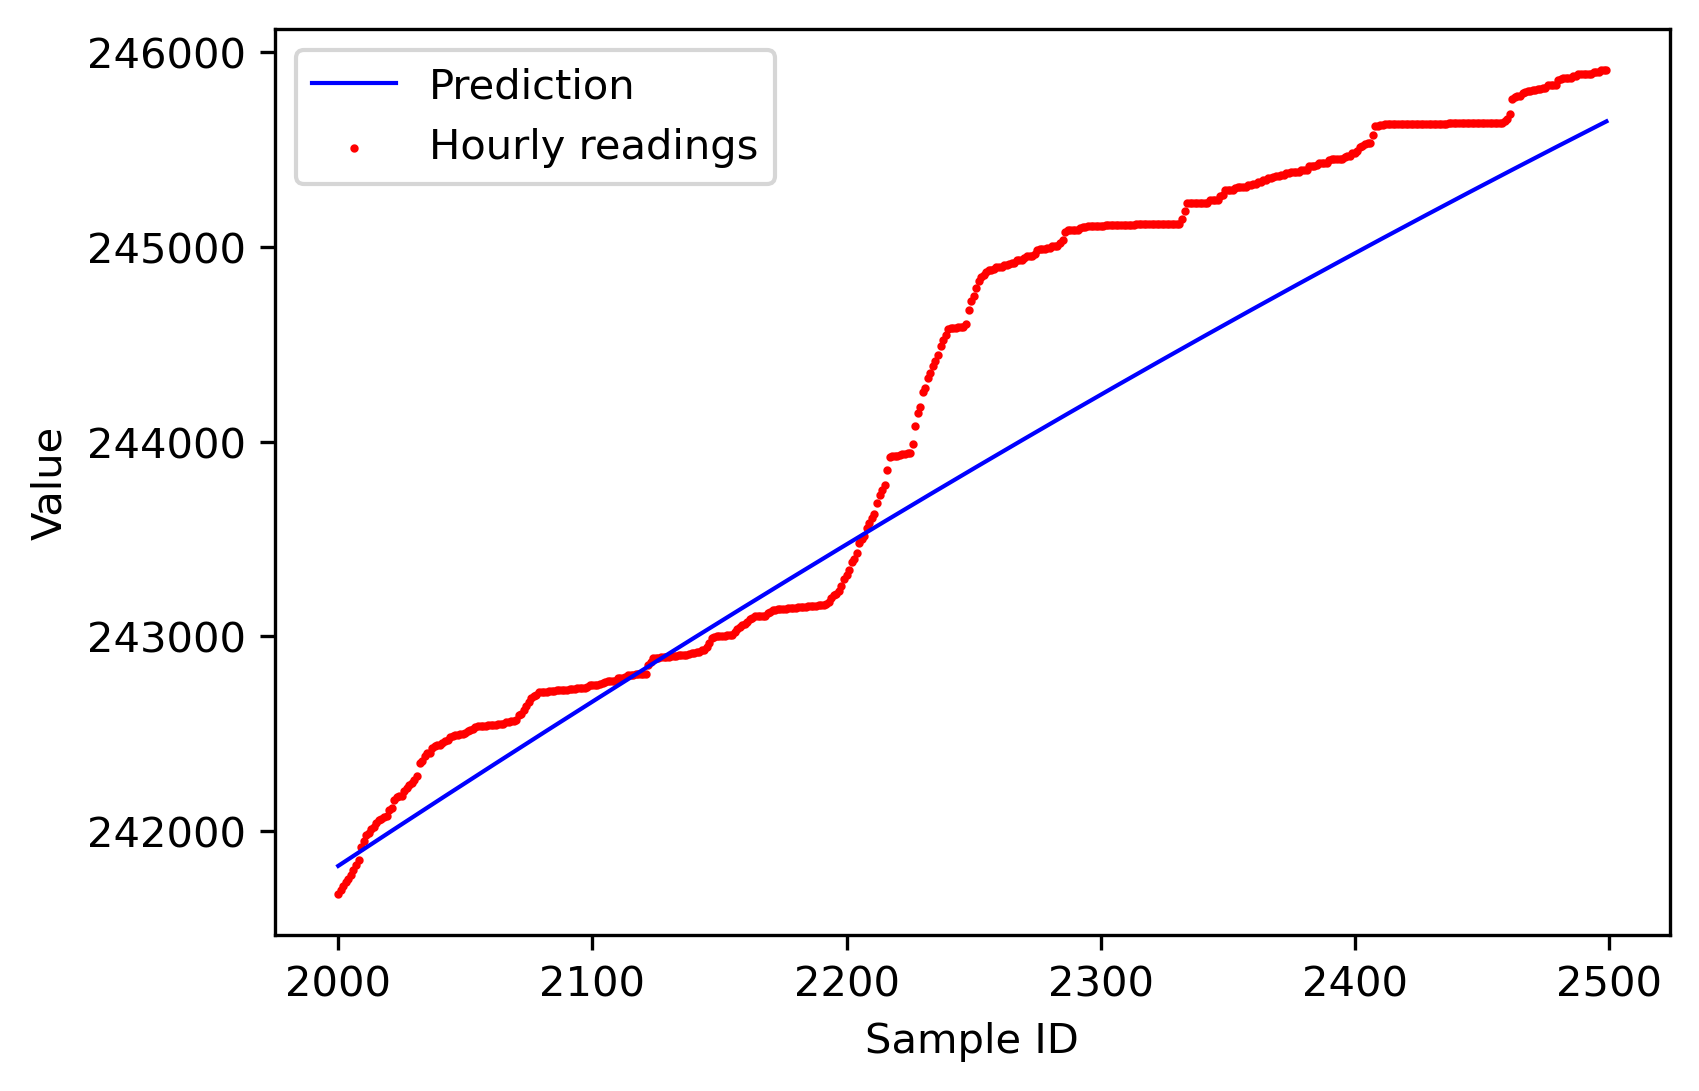

In [50]:
section = np.arange(2000, 2500)
# Plot outputs
plt.scatter(x[section], y[section],  color='red', s=1)
plt.plot(x[section], y_pred[section], color='blue', linewidth=1)
plt.xlabel('Sample ID')
plt.ylabel('Value')
plt.legend(['Prediction', 'Hourly readings'], loc='best')

In [18]:
# the mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y, y_pred))
# the coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y, y_pred))

Mean squared error: 117647.99
Coefficient of determination: 1.00


## Additional - Polynomial Regression

In [19]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
degree=4
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
polyreg.fit(x,y)
y_pred = polyreg.predict(x)

Additionally, we implement another method on data prediction : Polynomial Regression. 
Similarly, we use the hourly readings to support the prediction.

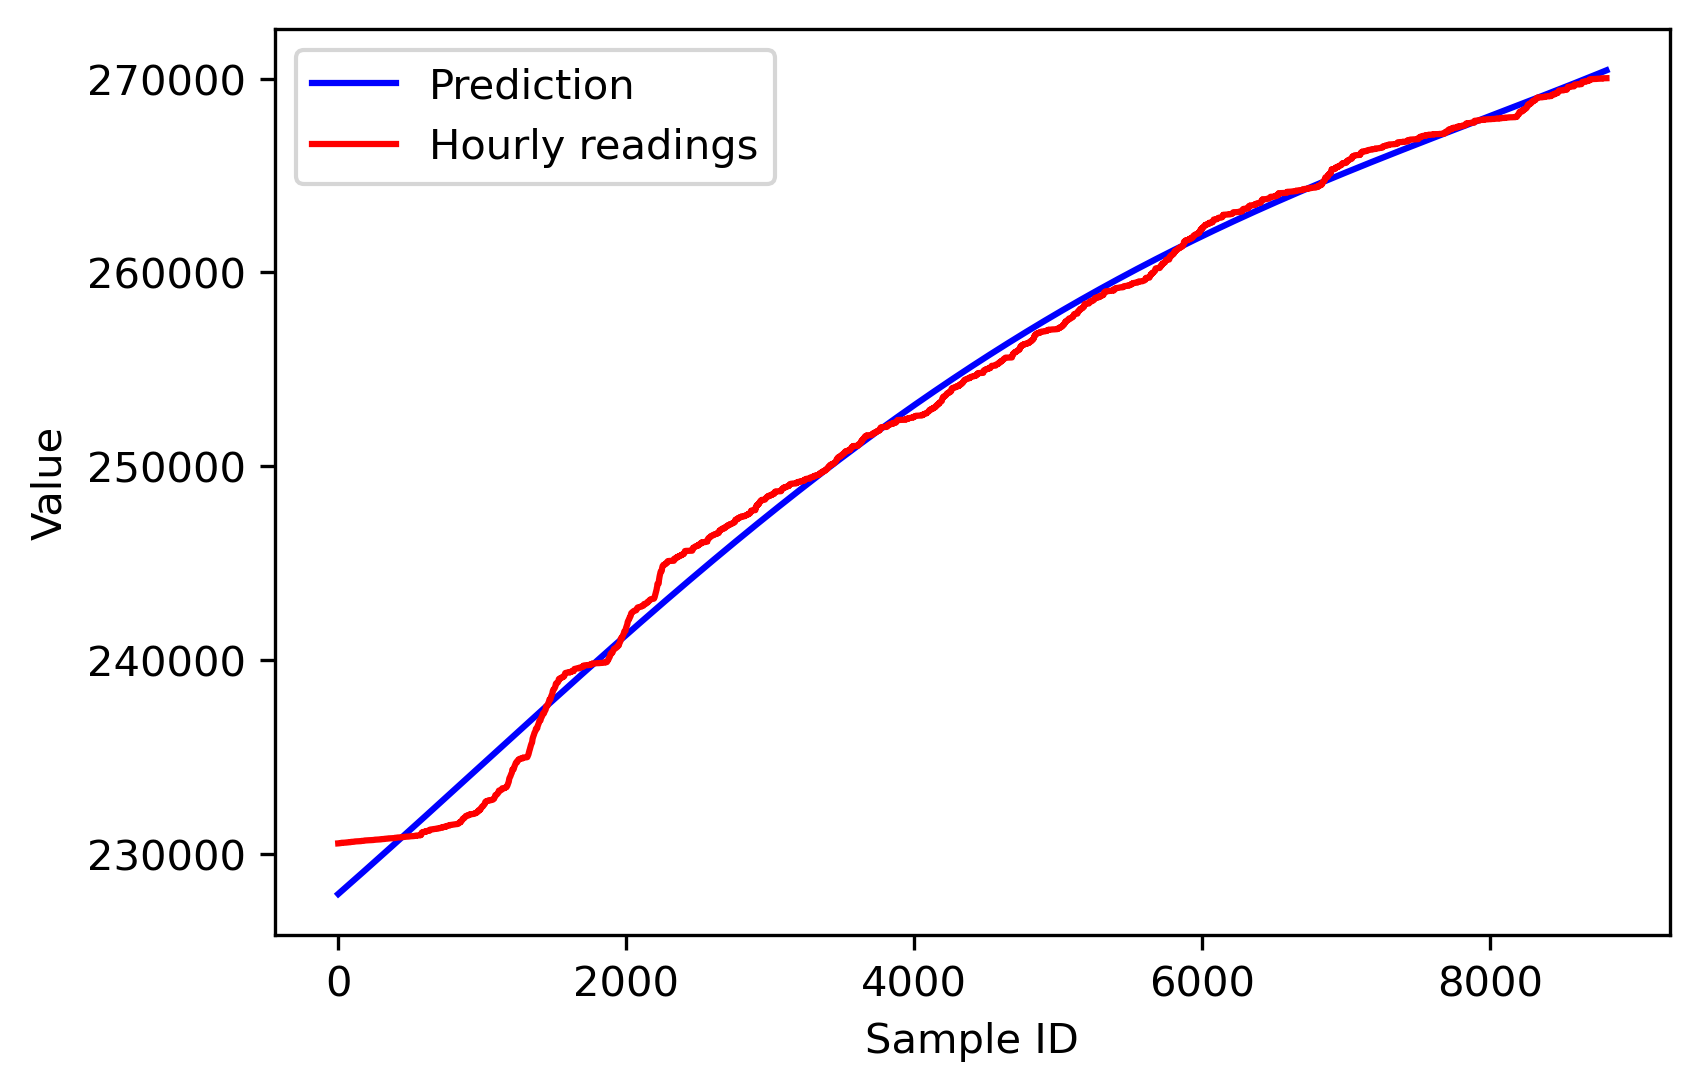

In [20]:
fig, ax = plt.subplots()
ax.plot(x, y_pred, '-b', label='Prediction')
ax.plot(x, y, '-r', label='Hourly readings')
plt.xlabel('Sample ID')
plt.ylabel('Value')
leg = ax.legend();

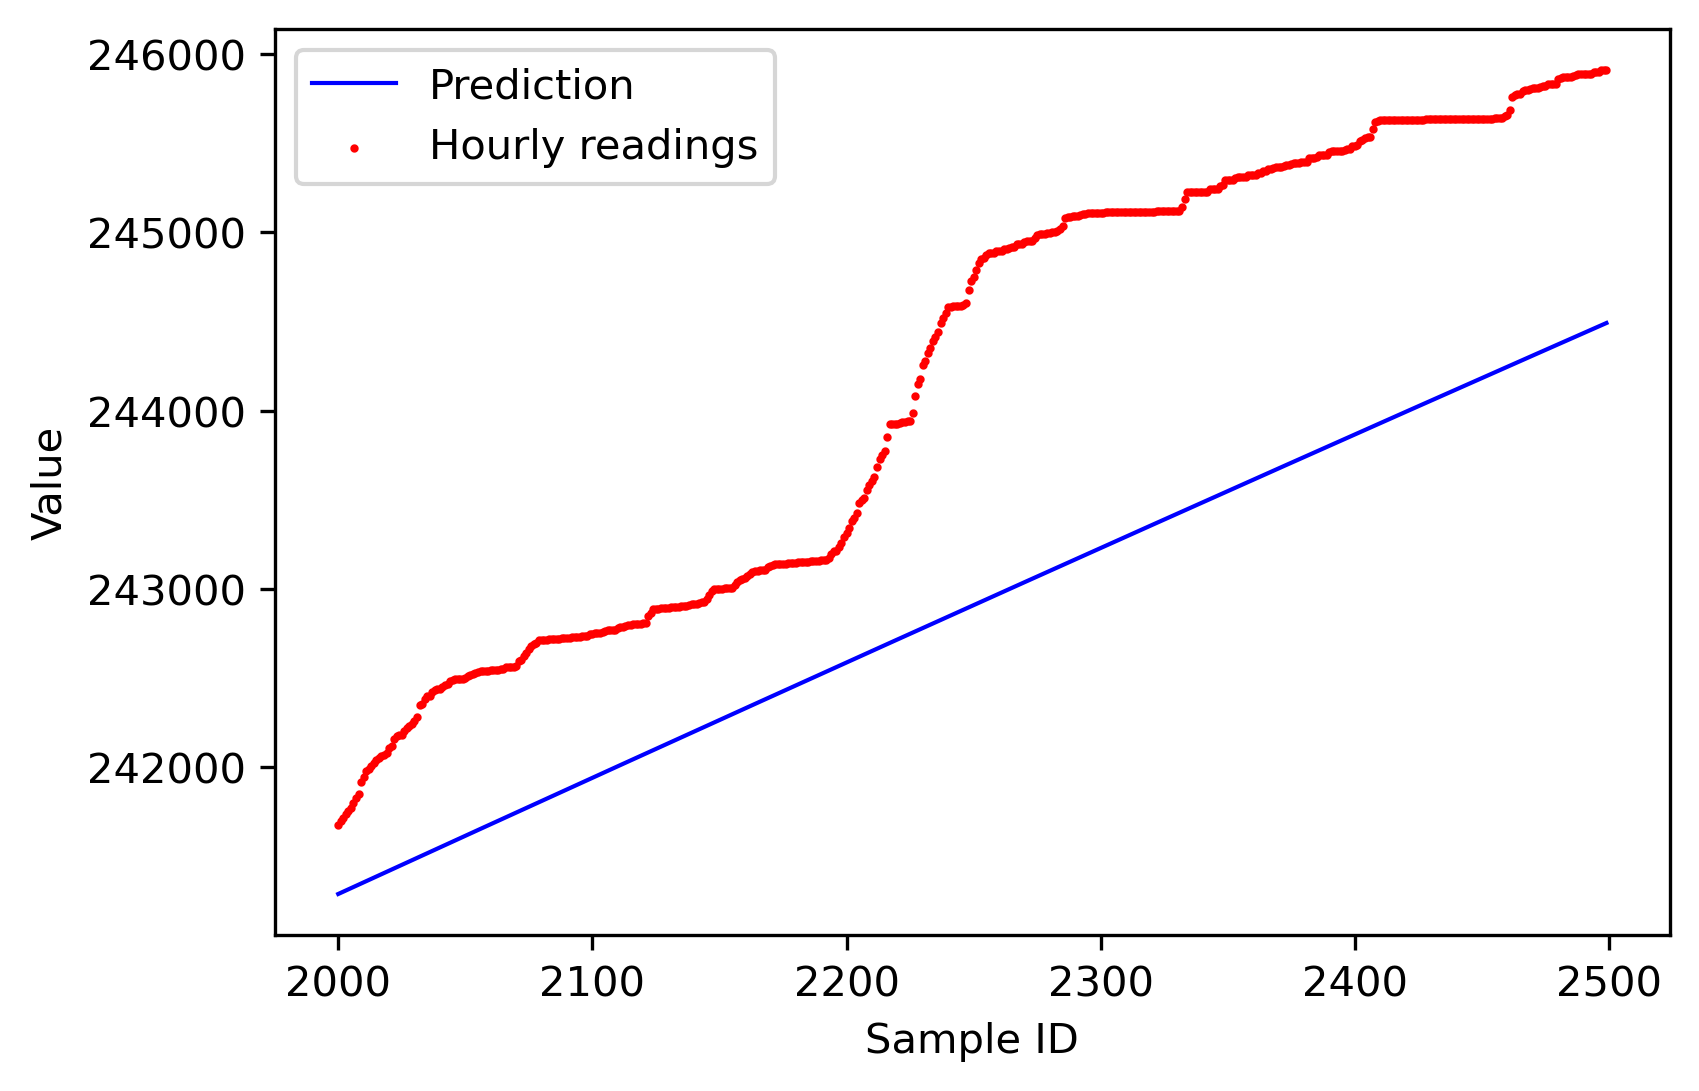

In [21]:
plt.scatter(x[section], y[section],  color='red', s=1)
plt.plot(x[section], y_pred[section], color='blue', linewidth=1)
plt.xlabel('Sample ID')
plt.ylabel('Value')
plt.legend(['Prediction', 'Hourly readings'], loc='best')

In [22]:
# the mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y, y_pred))
# the coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y, y_pred))

Mean squared error: 726952.90
Coefficient of determination: 1.00


It can be seen that the performance of polynomial regression in this case is better than linear regression but worse than SVR.